In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()
sns.set_context("notebook")

### Load Data

In [2]:
# load population data and rename columns
pop = pd.read_csv('State Populations.csv')
pop.columns = ['state','pop']
pop.head()

,state,pop
0,California,39776830
1,Texas,28704330
2,Florida,21312211
3,New York,19862512
4,Pennsylvania,12823989


In [3]:
# load state covid data and merge with pop data
s = pd.read_csv('us-states.csv')
s = pd.merge(s, pop, on='state')
s.head()

,date,state,fips,cases,deaths,pop
0,2020-01-21,Washington,53,1,0,7530552
1,2020-01-22,Washington,53,1,0,7530552
2,2020-01-23,Washington,53,1,0,7530552
3,2020-01-24,Washington,53,1,0,7530552
4,2020-01-25,Washington,53,1,0,7530552


In [4]:
# add in cases_per_1000 col
s['cases_per_1000'] = s['cases'] / s['pop'] * 1000
s.head()

,date,state,fips,cases,deaths,pop,cases_per_1000
0,2020-01-21,Washington,53,1,0,7530552,0.000133
1,2020-01-22,Washington,53,1,0,7530552,0.000133
2,2020-01-23,Washington,53,1,0,7530552,0.000133
3,2020-01-24,Washington,53,1,0,7530552,0.000133
4,2020-01-25,Washington,53,1,0,7530552,0.000133


In [5]:
def growth_by_group_rolling(df, group_col, value_col, window=5):
    return df.groupby(group_col)[value_col].pct_change().rolling(window=window).mean()

s['cases_growth'] = growth_by_group_rolling(s, 'state', 'cases')

# just looking at output
s.query('state == "New York" and cases > 100').head(10)

,date,state,fips,cases,deaths,pop,cases_per_1000,cases_growth
676,2020-03-08,New York,36,106,0,19862512,0.005337,1.542748
677,2020-03-09,New York,36,142,0,19862512,0.007149,0.710672
678,2020-03-10,New York,36,173,0,19862512,0.008710,0.554334
679,2020-03-11,New York,36,217,0,19862512,0.010925,0.405201
680,2020-03-12,New York,36,326,0,19862512,0.016413,0.301117
681,2020-03-13,New York,36,421,0,19862512,0.021196,0.321197
682,2020-03-14,New York,36,610,2,19862512,0.030711,0.343058
683,2020-03-15,New York,36,732,6,19862512,0.036853,0.339396
684,2020-03-16,New York,36,950,10,19862512,0.047829,0.348092
685,2020-03-17,New York,36,1374,17,19862512,0.069176,0.336894


### Growth vs Load Trend by State

In [16]:
def filter_column_by_values(df, filter_column, values):
    return df[df[filter_column].isin(values)]

include = ['California', 'Hawaii', 'Massachusetts', 'New York']
filtered_s = filter_column_by_values(s, 'state', include)

# just looking at output
filtered_s['state'].unique()

array(['California', 'Massachusetts', 'New York', 'Hawaii'], dtype=object)

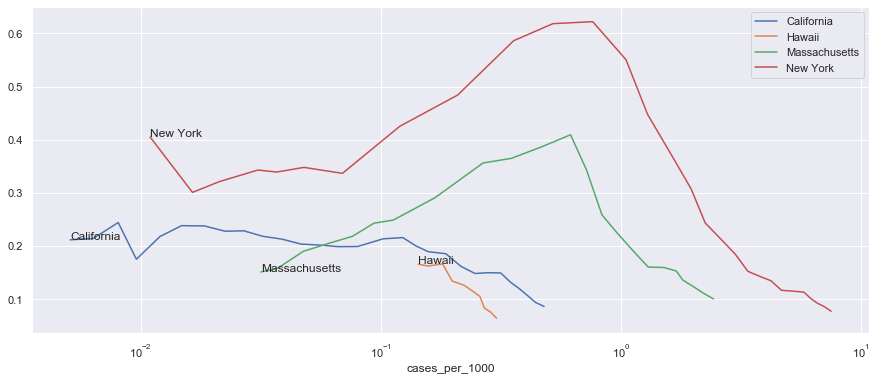

In [17]:
def graph_multiseries(df, series, x, y, logx=True):
    # limit to 200 cases
    df = df.query('cases > 200')
    
    fig, ax = plt.subplots(figsize=(15,6))
    
    # plot line per series
    for key, grp in df.groupby([series]):
        ax = grp.plot(ax=ax, kind='line', x=x, y=y, label=key, logx=logx)

    # label start point
    first_point = df.groupby(series)[[x,y]].first()
    for k, v in first_point[[x,y]].iterrows():
        ax.annotate(k, v)
    
    plt.legend(loc='best')
    plt.show()

    
graph_multiseries(filtered_s, 'state', 'cases_per_1000', 'cases_growth')

### Current Growth vs Load

In [8]:
current = s.groupby('state')[['cases_per_1000','cases_growth']].last()
current.head()

,cases_per_1000,cases_growth
state,,
Alabama,0.511153,0.102703
Alaska,0.303495,0.075529
Arizona,0.382656,0.090959
Arkansas,0.356584,0.079466
California,0.478746,0.086670


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


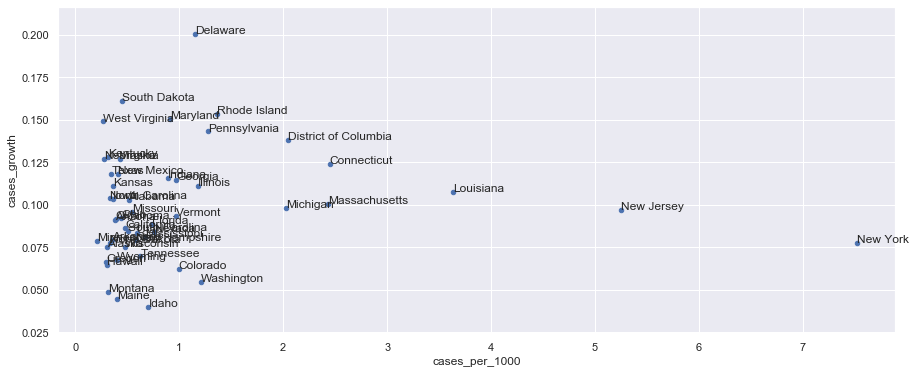

In [9]:
fig, ax = plt.subplots(figsize=(15,6))
current.plot(x='cases_per_1000', y='cases_growth', kind='scatter', ax=ax)

for k, v in current[['cases_per_1000','cases_growth']].iterrows():
    ax.annotate(k, v)
#fig.canvas.draw()


### Worst States

In [15]:
current['L2_norm'] = np.sqrt( (current['cases_per_1000'] / current['cases_per_1000'].max())**2
                             +(current['cases_growth']   / current['cases_growth'].max()  )**2)
current.sort_values(by='L2_norm', ascending=False).head(10)

,cases_per_1000,cases_growth,L2_norm
state,,,
New York,7.521758,0.077677,1.072227
Delaware,1.149118,0.200781,1.011602
New Jersey,5.251597,0.097018,0.849088
South Dakota,0.447715,0.161000,0.804077
Rhode Island,1.365719,0.153350,0.785055
Maryland,0.909435,0.150856,0.761011
West Virginia,0.267875,0.149115,0.743527
District of Columbia,2.046594,0.138039,0.739394
Pennsylvania,1.279945,0.143223,0.733346


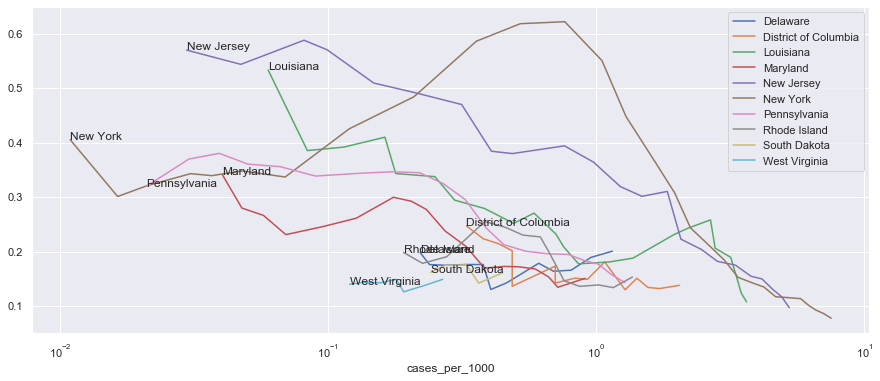

In [18]:
# get 10 worst states
include = current.sort_values(by='L2_norm', ascending=False).head(10).index.tolist()
filtered_s = filter_column_by_values(s, 'state', include)

graph_multiseries(filtered_s, 'state', 'cases_per_1000', 'cases_growth')